# フィラデルフィア半導体株指数 週足 メディアン統計

In [1]:
import sys
path_up = '..'
if not path_up in sys.path:
    sys.path.append(path_up)

In [2]:
import datetime

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import mplfinance as mpf
import numpy as np
import pandas as pd
import pingouin as pg
import seaborn as sns
import yfinance as yf

from funcs.technical import calc_robust_bollinger

In [3]:
code = 'SOX'
symbol = '^%s' % code
ticker = yf.Ticker(symbol)

In [4]:
# 週足で過去 5 年分のデータを取得
df0 = ticker.history(period='10y', interval='1wk')

# ローソク足のチャートには、そのうち過去 3 年分のみ使用する
dt_last = df0.index[len(df0) - 1]
tdelta_3y =  datetime.timedelta(days=365 * 3)
df = df0[df0.index >= dt_last - tdelta_3y]

## Moving Median

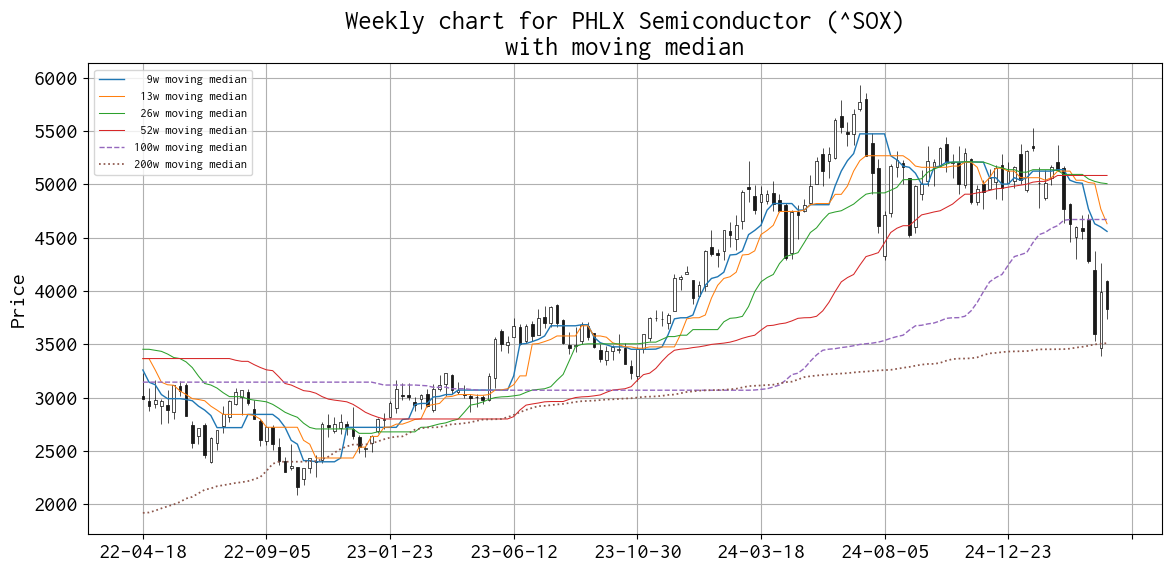

In [5]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 6))

mm09 = df0['Close'].rolling(9).median()
mm13 = df0['Close'].rolling(13).median()
mm26 = df0['Close'].rolling(26).median()
mm52 = df0['Close'].rolling(52).median()
mm100 = df0['Close'].rolling(100).median()
mm200 = df0['Close'].rolling(200).median()

apds  = [
    mpf.make_addplot(mm09[df.index], width=1, label='  9w moving median', ax=ax),
    mpf.make_addplot(mm13[df.index], width=0.75, label=' 13w moving median', ax=ax),
    mpf.make_addplot(mm26[df.index], width=0.75, label=' 26w moving median', ax=ax),
    mpf.make_addplot(mm52[df.index], width=0.75, label=' 52w moving median', ax=ax),
    mpf.make_addplot(mm100[df.index], width=1, linestyle='dashed', label='100w moving median', ax=ax),
    mpf.make_addplot(mm200[df.index], width=1.25, linestyle='dotted', label='200w moving median', ax=ax),
]   

mpf.plot(df, type='candle', style='default', datetime_format='%y-%m-%d', addplot=apds, xrotation=0, ax=ax)

ax.set_title('Weekly chart for %s (%s)\nwith moving median' %(ticker.info['longName'], symbol))
ax.grid()
ax.legend(loc='upper left', fontsize=9)

plt.tight_layout()
plt.savefig('report_weekly_chart_median_%s.png' % code)
plt.show()

In [6]:
df.tail(2)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2025-04-07 00:00:00-04:00,3460.449951,4265.020020,3388.620117,3990.899902,0,0.0,0.0
2025-04-14 00:00:00-04:00,4094.639893,4098.439941,3733.989990,3832.465820,0,0.0,0.0


In [7]:
df.tail(2)['Close']

Date
2025-04-07 00:00:00-04:00    3990.899902
2025-04-14 00:00:00-04:00    3832.465820
Name: Close, dtype: float64

In [8]:
df.tail(2)['Close'].diff()

Date
2025-04-07 00:00:00-04:00           NaN
2025-04-14 00:00:00-04:00   -158.434082
Name: Close, dtype: float64

In [9]:
df['Close'].tail(1) - df['Open'].tail(1)

Date
2025-04-14 00:00:00-04:00   -262.174072
dtype: float64

In [10]:
df['Close'].rolling(9).median().tail()

Date
2025-03-17 00:00:00-04:00    5009.339844
2025-03-24 00:00:00-04:00    4766.750000
2025-03-31 00:00:00-04:00    4629.589844
2025-04-07 00:00:00-04:00    4598.790039
2025-04-14 00:00:00-04:00    4557.950195
Name: Close, dtype: float64

In [11]:
df['Close'].rolling(13).median().tail()

Date
2025-03-17 00:00:00-04:00    5037.470215
2025-03-24 00:00:00-04:00    5015.850098
2025-03-31 00:00:00-04:00    5009.339844
2025-04-07 00:00:00-04:00    4766.750000
2025-04-14 00:00:00-04:00    4629.589844
Name: Close, dtype: float64

In [12]:
df['Close'].rolling(26).median().tail()

Date
2025-03-17 00:00:00-04:00    5092.135010
2025-03-24 00:00:00-04:00    5049.385010
2025-03-31 00:00:00-04:00    5026.660156
2025-04-07 00:00:00-04:00    5012.594971
2025-04-14 00:00:00-04:00    5005.385010
Name: Close, dtype: float64

In [13]:
df['Close'].rolling(52).median().tail()

Date
2025-03-17 00:00:00-04:00    5082.214844
2025-03-24 00:00:00-04:00    5082.214844
2025-03-31 00:00:00-04:00    5082.214844
2025-04-07 00:00:00-04:00    5082.214844
2025-04-14 00:00:00-04:00    5082.214844
Name: Close, dtype: float64

## Robust Bollinger bands

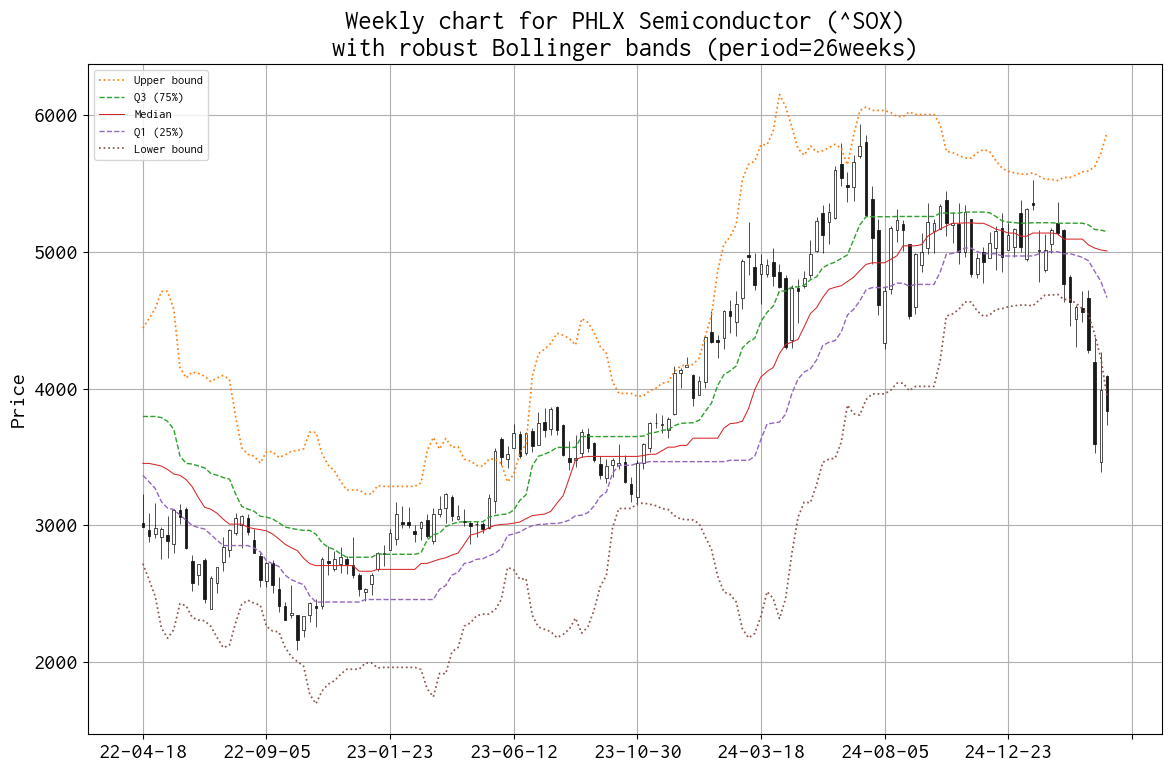

In [14]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams['font.family'] = font_prop.get_name()
plt.rcParams['font.size'] = 16

fig, ax = plt.subplots(figsize=(12, 8))

# Bollinger bands
period = 26
mv_median = df0['Close'].rolling(period).median()
mv_q1 = df0['Close'].rolling(period).quantile(.25)
mv_q3 = df0['Close'].rolling(period).quantile(.75)
mv_iqr = mv_q3 - mv_q1
mv_lower = mv_q1 - mv_iqr * 1.5
mv_upper = mv_q3 + mv_iqr * 1.5

apds  = [
    mpf.make_addplot(mv_upper[df.index], width=1.25, color='C1', linestyle='dotted', label='Upper bound', ax=ax),
    mpf.make_addplot(mv_q3[df.index], width=1, color='C2', linestyle='dashed', label='Q3 (75%)', ax=ax),
    mpf.make_addplot(mv_median[df.index], width=0.75, color='C3', label='Median', ax=ax),
    mpf.make_addplot(mv_q1[df.index], width=1, color='C4', linestyle='dashed', label='Q1 (25%)', ax=ax),
    mpf.make_addplot(mv_lower[df.index], width=1.25, color='C5', linestyle='dotted', label='Lower bound', ax=ax),
]   

mpf.plot(df, type='candle', style='default', addplot=apds, datetime_format='%y-%m-%d', xrotation=0, ax=ax)

ax.grid()
ax.legend(loc='best', fontsize=9)

try:
    ax.set_title('Weekly chart for %s (%s)\nwith robust Bollinger bands (period=%dweeks)' % (ticker.info['longName'], symbol, period))
except KeyError:
    ax.set_title('Weekly chart for %s\nwith robust Bollinger bands (period=%sweeks)' % (symbol, period))

plt.tight_layout()
plt.savefig('report_weekly_chart_bollinger_robust_%s.png' % code)
plt.show()

## ヒストグラム

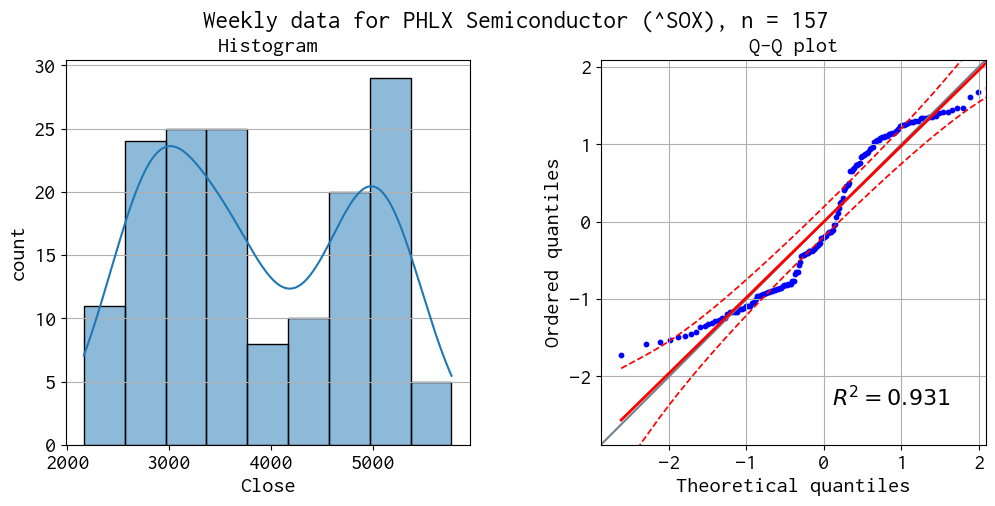

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.histplot(
    df['Close'],
    kde=True,
    ax=axes[0]
)

# ヒストグラム
axes[0].set_xlabel("Close")
axes[0].set_ylabel("count")
axes[0].grid(axis = 'y')
axes[0].set_title('Histogram', fontsize=16)

# Q-Q プロット
pg.qqplot(df['Close'], s=10,  ax=axes[1])
axes[1].set_title('Q-Q plot', fontsize=16)
axes[1].grid()

plt.suptitle('Weekly data for %s (%s), n = %d' % (ticker.info['longName'], symbol, len(df)), fontsize=18)
plt.subplots_adjust(wspace=0.3)
plt.savefig('report_weekly_histogram_qqplot_%s.png' % code)
plt.show()